# Group 2

## Import

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from xgboost import XGBRegressor
from xgboost import XGBClassifier
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

from pdpbox import pdp
import shap

In [46]:
df = pd.read_excel('dataproject2024.xlsx')
df

,ID,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,Default (y),Pred_default (y_hat),PD,Group
0,1,34,55,4875,3087,0,36,0.047895,0,1,1,0,0,0.024480,1
1,2,5,29,13000,13000,0,60,0.091667,0,0,0,1,0,0.331661,0
2,3,14,38,17190,14190,0,60,0.088235,0,0,0,0,0,0.187505,0
3,4,16,37,22773,23568,0,48,0.110084,0,1,1,0,0,0.035441,1
4,5,1,61,7700,8526,0,48,0.123404,0,1,0,1,0,0.340883,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7425,7426,9,38,4502,4856,0,48,0.083846,1,0,0,1,0,0.217708,0
7426,7427,1,33,22900,17900,0,60,0.098000,0,0,0,0,0,0.063937,0
7427,7428,3,27,25858,25972,0,24,0.181667,0,0,0,0,1,0.630863,0
7428,7429,6,32,12300,11300,0,72,0.091963,0,0,1,0,0,0.067551,0


## Step 1: Use the estimated default probability (PD) provided in the dataset. Implement one or two surrogate model(s) to interpret the unknown model used to generate PD.

**We use the unknown model's predictions (`PD`) as the target variable and use original features to train our surrogate model**

In [47]:
y = df['PD']
X = df[['Job tenure', 'Age', 'Car price', 'Funding amount', 'Down payment', 'Loan duration', 'Monthly payment', 'Credit event', 'Married', 'Homeowner']]


# train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### First surrogate: LinearRegression

First we build the surrogate model

In [48]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.025293393693871593
R-squared: 0.42325844480117003


Then we interpret the coefficients

           Feature  Coefficient
0       Job tenure    -0.002953
1              Age    -0.001269
2        Car price    -0.000021
3   Funding amount     0.000026
4     Down payment     0.081968
5    Loan duration     0.001142
6  Monthly payment     0.291974
7     Credit event     0.315471
8          Married    -0.072892
9        Homeowner    -0.064714


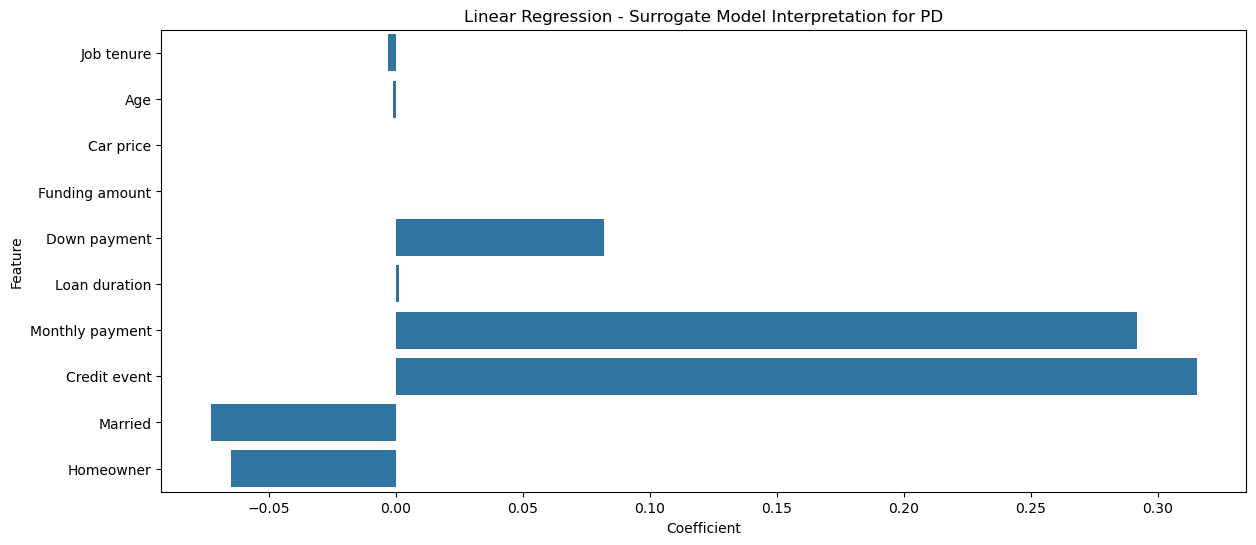

In [49]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
})

print(coefficients)

# plotting
plt.figure(figsize=(14,6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Linear Regression - Surrogate Model Interpretation for PD')
plt.show()

This plot helps in interpreting the unknown model! We see how different features have an impact on the estimated default probability. For instance:

- **Credit event** has the largest positive coefficient. This means that if a credit event occurred it significantly increases the probability of default. This suggests that credit history plays a crucial role in predicting default likelihood

- **Monthly payment** also has a big positive effect meaning that higher monthly payments are associated with a higher probability of default. This could be due to the financial burden of higher loan payments on the borrower

- **Marital status** and **Homeownership** on the other hand have negative coefficients implying that being married or a homeowner reduces the probability of default. These factors might indicate more financial stability, leading to lower risk

### Second surrogate: DecisionTreeRegressor

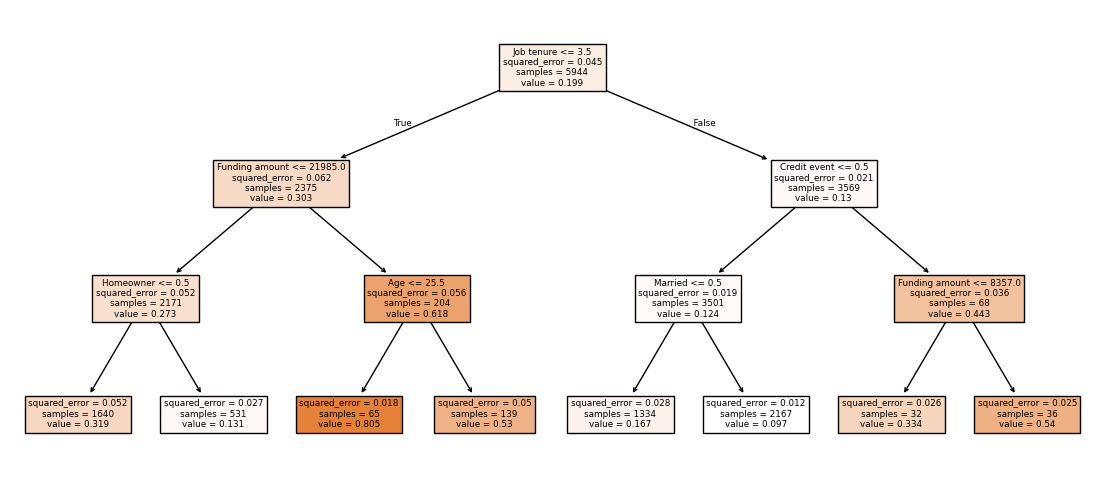

Train Score: 0.35382098105428017
Test Score: 0.30911991669819894


In [54]:
surrogate_model = DecisionTreeRegressor(max_depth=3, random_state=42)
surrogate_model.fit(X_train, y_train)

plt.figure(figsize=(14,6))
plot_tree(surrogate_model, feature_names=X.columns, filled=True)
plt.show()

train_score = surrogate_model.score(X_train, y_train)
test_score = surrogate_model.score(X_test, y_test)

print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

## Step 2: Estimate your own black-box machine learning model forecasting default. Each model is specific to a group of students and cannot be developed in collaboration with another group.

We often use XGBoost for its powerful and flexible ML algorithms but in fact it can be considered a black-box model and although it often leads to very good results, it is often hard to interpret them !

In [7]:
df.columns

Index(['ID', 'Job tenure', 'Age', 'Car price', 'Funding amount',
       'Down payment', 'Loan duration', 'Monthly payment', 'Credit event',
       'Married', 'Homeowner', 'Default (y)', 'Pred_default (y_hat)', 'PD',
       'Group'],
      dtype='object')

In [8]:
y = df['Default (y)']
X = df[['Job tenure', 'Age', 'Car price', 'Funding amount', 'Down payment', 'Loan duration', 'Monthly payment', 'Credit event', 'Married', 'Homeowner']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, objective='binary:logistic')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.8129205921938089
Confusion Matrix:
[[1143   62]
 [ 216   65]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1205
           1       0.51      0.23      0.32       281

    accuracy                           0.81      1486
   macro avg       0.68      0.59      0.61      1486
weighted avg       0.78      0.81      0.78      1486



In order to make the model more performant (and more complex as we are creating a black-box !) we hyper-parameter tune our model using optuna:

In [11]:
def objective(trial):
    # tuning hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'base_score': trial.suggest_float('base_score', 0.5, 0.7),
        'random_state': 42
    }

    xgb_model = XGBClassifier(**param, objective='binary:logistic')
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred = xgb_model.predict(X_test)

    return 1 - accuracy_score(y_test, y_pred)  # minimize error

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

[I 2024-09-25 14:29:45,518] A new study created in memory with name: no-name-c284b4fc-98be-48fa-a97d-83b352563fc5
[I 2024-09-25 14:29:45,694] Trial 0 finished with value: 0.3216689098250336 and parameters: {'n_estimators': 193, 'max_depth': 4, 'learning_rate': 0.0032402876169332013, 'subsample': 0.967831613397631, 'colsample_bytree': 0.9639105646257407, 'gamma': 6.504852224403843, 'reg_alpha': 1.1108523547544743e-06, 'reg_lambda': 4.227148551355274e-07, 'min_child_weight': 7, 'scale_pos_weight': 2.0844131327898436, 'eta': 0.26209820370562276, 'base_score': 0.6346636708228963}. Best is trial 0 with value: 0.3216689098250336.
[I 2024-09-25 14:29:46,076] Trial 1 finished with value: 0.4751009421265141 and parameters: {'n_estimators': 286, 'max_depth': 8, 'learning_rate': 0.0021507224461529283, 'subsample': 0.5831184260838108, 'colsample_bytree': 0.618483803128398, 'gamma': 4.685463251851622, 'reg_alpha': 2.370290570169402e-05, 'reg_lambda': 3.4797211078000077e-06, 'min_child_weight': 5, '

In [12]:
best_params = study.best_params
print(f"Best hyperparameters: {study.best_params}")

xgb_model = XGBClassifier(**best_params, objective='binary:logistic')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Best hyperparameters: {'n_estimators': 1207, 'max_depth': 10, 'learning_rate': 0.018923561402806252, 'subsample': 0.8428650336687261, 'colsample_bytree': 0.41972448144699925, 'gamma': 4.950418679537689, 'reg_alpha': 0.9432012569880011, 'reg_lambda': 0.3721025076784593, 'min_child_weight': 6, 'scale_pos_weight': 1.162637674990414, 'eta': 0.15922328211666892, 'base_score': 0.6035832183085174}
Accuracy: 0.8324360699865411
Confusion Matrix:
[[1165   40]
 [ 209   72]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1205
           1       0.64      0.26      0.37       281

    accuracy                           0.83      1486
   macro avg       0.75      0.61      0.63      1486
weighted avg       0.81      0.83      0.80      1486



## Step 3: Analyze the forecasting performance of your own model.

In [17]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.8324360699865411
Confusion Matrix:
[[1165   40]
 [ 209   72]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1205
           1       0.64      0.26      0.37       281

    accuracy                           0.83      1486
   macro avg       0.75      0.61      0.63      1486
weighted avg       0.81      0.83      0.80      1486



Visualize Predicted vs. Actual Values

In [18]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [19]:
y_test

625     1
2796    0
101     1
4767    0
2018    0
       ..
434     0
751     1
2183    0
1872    1
6412    0
Name: Default (y), Length: 1486, dtype: int64

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

# Calculate Precision, Recall, F1 Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.6428571428571429
Recall: 0.25622775800711745
F1 Score: 0.366412213740458


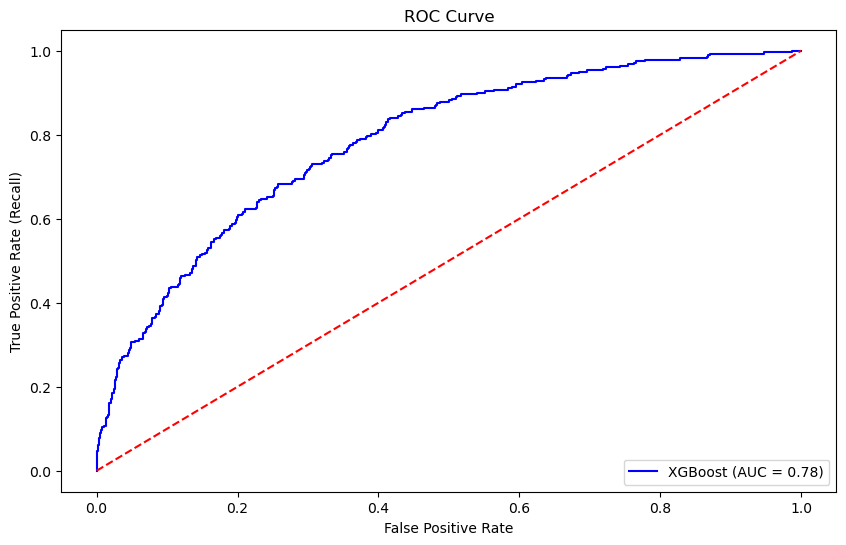

ROC AUC Score: 0.7840197280016538


In [21]:
# ROC Curve and AUC
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for positive class
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f"ROC AUC Score: {roc_auc}")

**0.78** indicates that the model is doing well at distinguishing between default vs non-default

## Step 4: Global interpretability: Implement one or two surrogate model(s) to interpret your own model. Compare the results provided in Steps 1 and 4.

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

y_surrogate_class = xgb_model.predict(X_train)

### Logistic Regression surrogate

In [56]:
log_reg_surrogate = LogisticRegression()
log_reg_surrogate.fit(X_train, y_surrogate_class)

y_log_reg_pred = log_reg_surrogate.predict(X_test)

### Coefficients for Logistic Regression surrogate

Logistic Regression Coefficients:
           Feature  Coefficient
0       Job tenure    -0.298746
1              Age    -0.090491
2        Car price    -0.000464
3   Funding amount     0.000631
4     Down payment    -0.131310
5    Loan duration     0.011162
6  Monthly payment     0.075342
7     Credit event     2.025851
8          Married    -2.434937
9        Homeowner    -1.672705


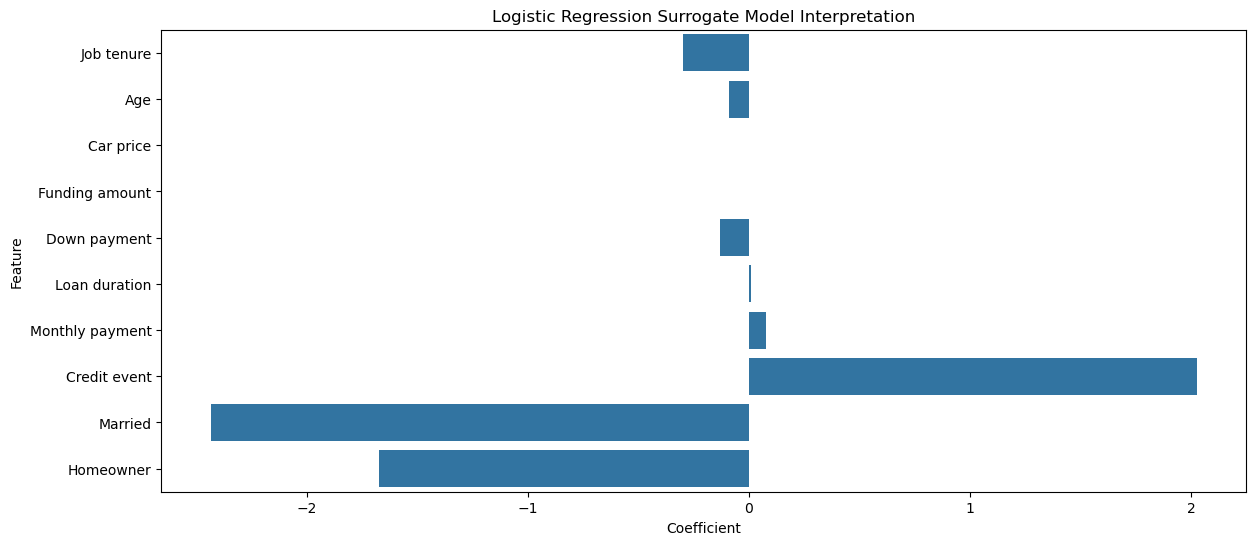

Logistic Regression Surrogate Accuracy on training data: 0.9552489905787349


In [58]:
coefficients_log_reg = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg_surrogate.coef_[0]
})

print("Logistic Regression Coefficients:")
print(coefficients_log_reg)

# Plotting coefficients
plt.figure(figsize=(14,6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_log_reg)
plt.title('Logistic Regression Surrogate Model Interpretation')
plt.show()

# Evaluate surrogate accuracy
log_reg_accuracy = accuracy_score(y_surrogate_class, log_reg_surrogate.predict(X_train))
print(f"Logistic Regression Surrogate Accuracy on training data: {log_reg_accuracy}")

The Logistic Regression surrogate provides insight into how each feature affects the probability of default:

- **Credit Event** has the largest positive coefficient (2.03), indicating that having a credit event significantly increases the probability of default
- **Monthly Payment** and **Funding Amount** also show positive coefficients, suggesting higher values increase default risk, though their impact is smaller
- **Marital Status** and **Homeownership** have large negative coefficients, indicating that being married (-2.43) or a homeowner (-1.67) significantly reduces the probability of default, likely reflecting greater financial stability
- **Job Tenure** has a modest negative effect, implying longer employment reduces default risk

### Decision tree classifier surrogate model

In [70]:
from sklearn.tree import DecisionTreeClassifier

dt_surrogate_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_surrogate_classifier.fit(X_train, y_surrogate_class)

y_dt_class_pred = dt_surrogate_classifier.predict(X_test)

### Feature importance for the Decision Tree classifier surrogate

Decision Tree Surrogate Classifier Train Accuracy: 0.9535666218034994
Decision Tree Surrogate Classifier Test Accuracy: 0.8909825033647375

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1309
           1       0.59      0.29      0.39       177

    accuracy                           0.89      1486
   macro avg       0.75      0.63      0.66      1486
weighted avg       0.87      0.89      0.87      1486

Decision Tree Classifier Feature Importances:
           Feature  Importance
1              Age    0.358221
0       Job tenure    0.181030
5    Loan duration    0.158854
3   Funding amount    0.130756
7     Credit event    0.108617
6  Monthly payment    0.062521
2        Car price    0.000000
4     Down payment    0.000000
8          Married    0.000000
9        Homeowner    0.000000


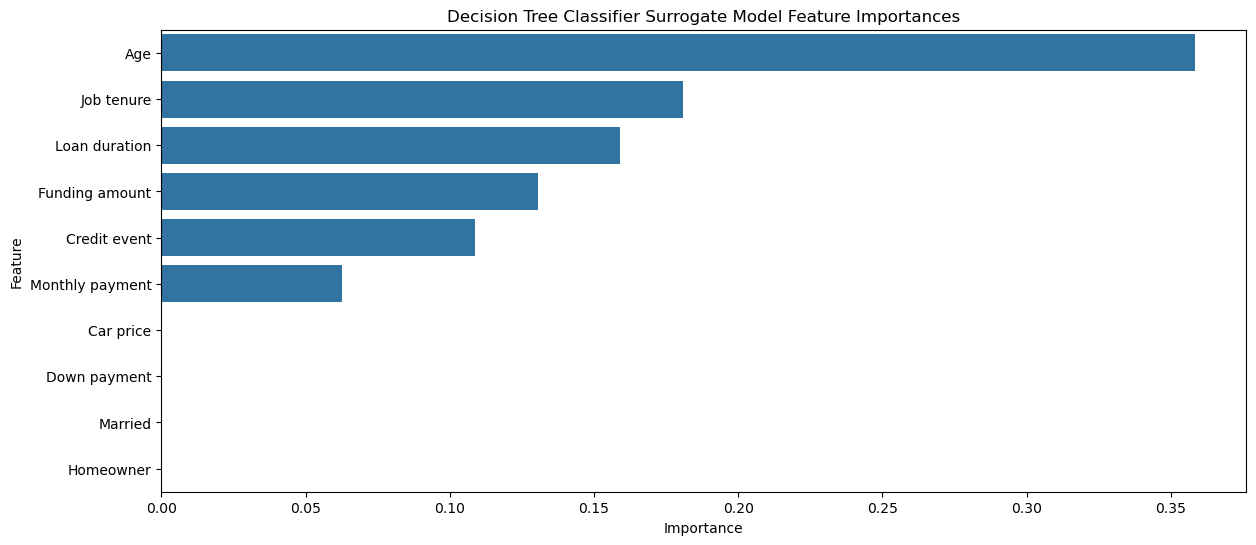

In [75]:
y_test_binary = (y_test >= 0.5).astype(int) # fixing error continuous ?

dt_surrogate_accuracy = accuracy_score(y_surrogate_class, dt_surrogate_classifier.predict(X_train))
test_accuracy = accuracy_score(y_test_binary, y_dt_class_pred)

print(f"Decision Tree Surrogate Classifier Train Accuracy: {dt_surrogate_accuracy}")
print(f"Decision Tree Surrogate Classifier Test Accuracy: {test_accuracy}")
print("\nClassification Report (Test Data):")
print(classification_report(y_test_binary, y_dt_class_pred))

feature_importance_dt_class = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_surrogate_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Decision Tree Classifier Feature Importances:")
print(feature_importance_dt_class)

# feature importances
plt.figure(figsize=(14,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_dt_class)
plt.title('Decision Tree Classifier Surrogate Model Feature Importances')
plt.show()

The Decision Tree Classifier surrogate achieved a high train accuracy (95.36%) and a good test accuracy (89.10%), indicating that it approximates the XGBoost model’s behavior effectively on unseen data

Regarding feature importance, **Age** (35.8%), **Job Tenure** (18.1%), and **Loan Duration** (15.9%) are the most significant features influencing the default predictions. Features such as **Car Price**, **Down Payment**, **Marital Status**, and **Homeownership** had no impact in this surrogate model

## Step 5: Global interpretability: Implement the PDP method to interpret your own model. Compare the results provided in Steps 4 and 5.

## Step 6: Local interpretability: Implement the ICE method to interpret your own model.

## Step 7: Local interpretability: Implement the SHAP method to interpret your own model. Compare the results provided in Steps 6 and 7.

## Step 8: Performance interpretability: Implement the permutation importance method and/or the XPER method to identify the main drivers of the predictive performance of your model. Are the drivers of the performance metric (Step 8) similar to the drivers of the individual forecasts identified by SHAP (Step 7).

## Step 9: Assess the fairness of your own model with respect to age (protected attribute). Use a statistical test for the following three fairness definitions: Statistical Parity and Conditional Statistical Parity (groups are given in the dataset). Discuss your results.

## Step 10: Implement a FPDP using a fairness measure. Discuss your results.